# Processamento do Dataset

## Função para ler os dados do Dataset e processar

- Substitui dados vazios da coluna Levy(Taxas) pela media
- Aplica um processamento de texto para remover o texto km da coluna Mileahe(Milhas)
- Extrai apenas o valor do volume do motor
- Remove colunas desnecessarias ou dificeis de processar como ID e Model
- Remove os valores muito fora da media das colunas numericas

### Aplica uma normaliçao numerica

Utilizado a funçao log1p (log(1 + x)) para preservars valores 0 e normalizar os dados,
dessa forma, muito comum quando os dados são muito assimetricos, facilita o processamento com a IA.

Apos isso, para reverter os dados ao estado original, usei a funçao expm1 ( exp(x) - 1 )


In [1]:
import pandas as pd
import numpy as np

def process_data():
    data = pd.read_csv("./car_price_prediction.csv", sep=",")

    data['Levy'] = pd.to_numeric(data['Levy'], errors='coerce')
    levy_med = data['Levy'].median()
    data['Levy'].fillna(levy_med, inplace=True)

    data['Mileage'] = data['Mileage'].str.replace(' km', '', regex=False).astype(float)

    data['Engine volume'] = data['Engine volume'].str.extract(r'(\d+\.?\d*)').astype(float)

    data = data.drop(columns=['ID', 'Model'])

    num_columns = ['Price', 'Levy', 'Mileage', 'Engine volume']
    for col in num_columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        data = data[~((data[col] < lower_bound) | (data[col] > upper_bound))]


    data['Price'] = np.log1p(data['Price']) 
    data['Mileage'] = np.log1p(data['Mileage'])
    data['Levy'] = np.log1p(data['Levy'])

    y = data['Price']
    x = data.drop(columns=["Price"])

    return x, y


# Funçao de build do modelo

## Constroi as camadas de neuronios e aplica as funções matematicas

1. Camada de Input(entrada) - 64 neuronios
2. Camada escondida - 32 neuronios
3. Camada escondida - 16 neuronios
4. Cama escondida - 8 neuronios
5. Camada de saida

### Funçoes adicionais

- Nas camadas é aplicado o L2 regularization. Altera a penalidade da funçao de perda, para que a Ia
não dependa muito de pesos muito altos.

- Dropout: Aplicado entre as Layers para ignorar uma porcentagem dos neuronios, tambem ajuda a IA
a não depender muito de neuronios especificos.

- BatchNormalization: normaliza os outputs das camadas para garantir que eles tenham uma media de 0 e um desvio
padrão de 1, o que ajuda a encontrar padrões mais rapido


In [2]:
from keras.api.models import Sequential
from keras.api.layers import Dense, BatchNormalization, Dropout
from keras.api.optimizers import Adam
from keras.api.regularizers import l2


def build_model(dimension, func='relu', eta=0.001):
    model = Sequential([
        Dense(64, activation=func, input_dim=dimension, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation=func, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(16, activation=func, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.1),

        Dense(8, activation=func, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.03),

        Dense(1)
    ])

    optimizer = Adam(learning_rate=eta)
    model.compile(optimizer=optimizer, loss='huber', metrics=['mae'])

    return model

# Função de Treinamento do Modelo

## Pré-processamento dos Dados
- A função começa dividindo o conjunto de dados em conjuntos de treino e teste, com 80% dos dados para treinamento e 20% para teste.

#### Transformadores e Escaladores
- Para as variáveis numéricas, a transformação `StandardScaler` é aplicada para normalizar os dados, removendo a média e escalando para que a variância seja 1.
- Para as variaveis categoricas, `OneHotEncoder` cria colunas binárias para representar cada categoria

---

## Construção do Modelo
**Callbacks do Keras utilizdos para melhorar o treinamento**:
   - **EarlyStopping**: Para evitar o overfitting, é aplicado um monitoramento do `val_loss`, que interrompe o treinamento caso a perda de validação não melhore após 15 épocas.
   - **ReduceLROnPlateau**: Reduz a taxa de aprendizado se a perda de validação não melhorar após 5 épocas, ajustando dinamicamente a taxa de aprendizado.

---

## Avaliação do Modelo

**Métricas de Performance**:
   - **Erro Absoluto Médio (MAE)**: Mede a diferença média entre o preço real e o preço previsto, dando uma ideia do erro médio do modelo.
   - **Erro Quadrático Médio (MSE)**: Penaliza erros maiores, pois eleva os erros ao quadrado.
   - **Raiz do Erro Quadrático Médio (RMSE)**: A raiz quadrada do MSE, traz o erro de volta a escala dos preçoes.
   - **Coeficiente de Determinação (R²)**: Mede a proporção da variabilidade do preço. Valores mais próximos de 1 indicando bons resultados.

---

## Visualização dos Resultados

1. **Curvas de Perda (Loss)**: 
   - A evolução da perda durante o treinamento e validação é plotada para acompanhar o progresso do modelo e verificar se está ocorrendo overfitting.

2. **Gráfico de Preço Real vs. Preço Predito**:
   - Grafico de disperção com uma linha vermelha indicando o valor correto, e o que foi chutado pela IA

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.api.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

def train_model():
    x, y = process_data()

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=42
    )

    numeric_features = [
        'Levy', 'Prod. year', 'Engine volume', 
        'Mileage', 'Cylinders', 'Airbags', 'Doors'
    ]
    
    categorical_features = [
        'Manufacturer', 'Category', 'Leather interior',
        'Fuel type', 'Gear box type', 'Drive wheels',
        'Wheel', 'Color'
    ]

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])
    
    x_train_processed = preprocessor.fit_transform(x_train)
    x_test_processed = preprocessor.transform(x_test)

    model = build_model(x_train_processed.shape[1], eta=0.01)

    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )
    ]


    history = model.fit(
        x_train_processed, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=64,
        callbacks=callbacks,
        verbose=1
    )

    y_pred = model.predict(x_test_processed)
    
    y_pred_original = np.expm1(y_pred)
    y_test_original = np.expm1(y_test)
    
    mae = mean_absolute_error(y_test_original, y_pred_original)
    mse = mean_squared_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_original, y_pred_original)
    
    # Graficos e analises para avaliar o treinamento da IA

    print("\nTraining Results:")
    print(f"Mean Absolute Error: ${mae:,.2f}")
    print(f"Root Mean Squared Error: ${rmse:,.2f}")
    print(f"R² Score: {r2:.4f}")

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.scatter(y_test_original, y_pred_original, alpha=0.6, label='Predicted vs Actual')
    plt.plot([y_test_original.min(), y_test_original.max()], 
             [y_test_original.min(), y_test_original.max()], color='red', linestyle='--', label='Perfect Prediction')
    plt.title('Actual vs. Predicted Prices')
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.legend()
    plt.grid()
    plt.show()
    


## Inicio do treinamento do modelo

C:\Users\akdag\AppData\Local\Temp\ipykernel_9936\3898627256.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Levy'].fillna(levy_med, inplace=True)
c:\Users\akdag\Desktop\CarPriceAI\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 6.2732 - mae: 6.2434 - val_loss: 0.8162 - val_mae: 1.0136 - learning_rate: 0.0100
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7968 - mae: 0.9685 - val_loss: 0.6871 - val_mae: 0.8601 - learning_rate: 0.0100
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7270 - mae: 0.9284 - val_loss: 0.6643 - val_mae: 0.8298 - learning_rate: 0.0100
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7097 - mae: 0.9107 - val_loss: 0.5384 - val_mae: 0.7301 - learning_rate: 0.0100
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6401 - mae: 0.8752 - val_loss: 0.5796 - val_mae: 0.7461 - learning_rate: 0.0100
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6788 - mae: 0.9030 - val_loss: 0.5608 - val_mae: 0.7482 - learning_rate: 0.0100
Epoch 7/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6835 - mae: 0.9114 - val_loss: 0.5674 - val_mae: 0.7797 - learning_rate: 0.0100

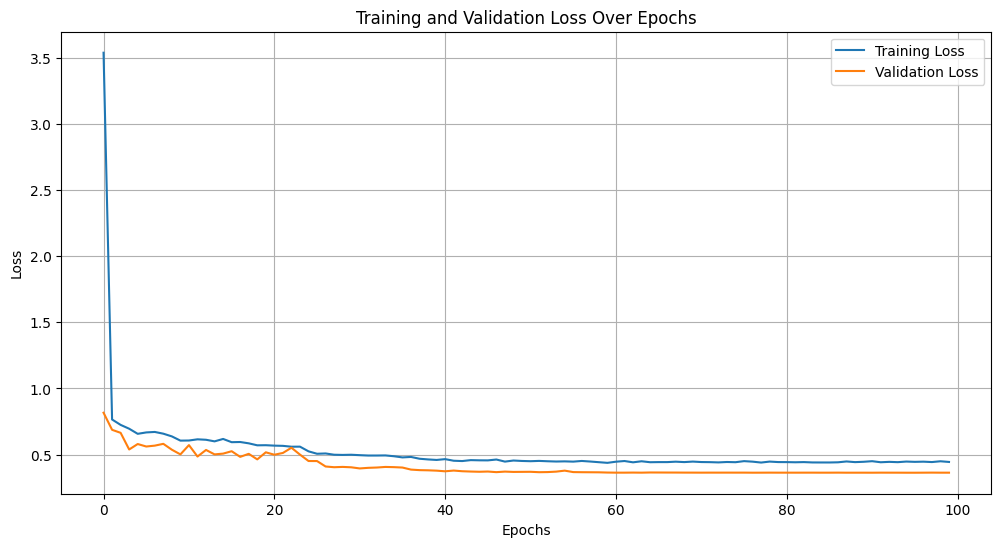

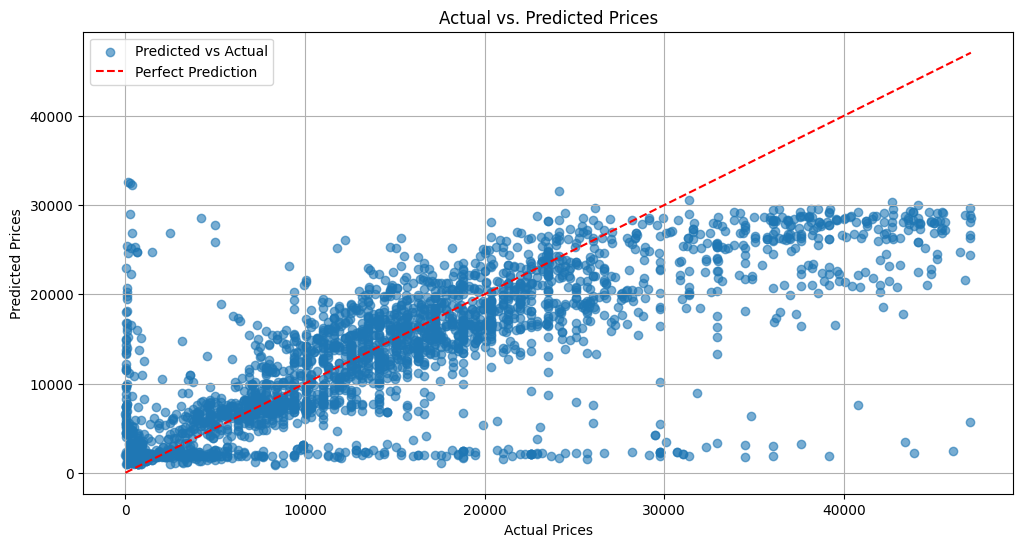

In [4]:
train_model()

# Resultados - RELU
## Test 2

Aumentando a ETA inicial para 0.01, divisao(batch size) para 64, o modelo treinou muito mais rapido
porem os resultados foram inferiores.

- Funcao: Relu
- Epocas: 100
- Divisão dos dados: 64
- Taxa de aprendizdo inicial (varia com as epocas): 0.01
---

Erro médio absolute nas predições(`MAE`): $4,693.93

Erro quadratico médio (`RMSE`): $7,358.61

Coenficiente de determinação (`R² Score`): 0.5715